In [1]:
from sklearn import decomposition
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df_scaled = pd.read_csv('rfm_plus_scaled.csv')
df = pd.read_csv('rfm_plus.csv')

# Description du fichier:
L'objectif de ce notebook est de faire des essais sur des methodes de classification et des variables de notre base de donnee **rfm_plus.csv** dans le but de trouver la classification qui satisfait les besoins de l'equipe marketing en ce basant sur 2 criteres: Un nombre raisonnable de cluster et une pertinence de la classification qui doit etre utiles pour les objectifs du marketing.

# Essais sur le jeu de donnees complet

## 1- PCA
On commence par le PCA sur le jeu de donnee complet afin de voir les effets des differentes variables. 

In [2]:
pca = decomposition.PCA(n_components=3)
pca.fit(df_scaled)

PCA(n_components=3)

In [3]:
df_pca = pca.transform(df_scaled)

In [4]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.28986039 0.19967257 0.16900666]
0.6585396189386457


(-0.7, 0.7)

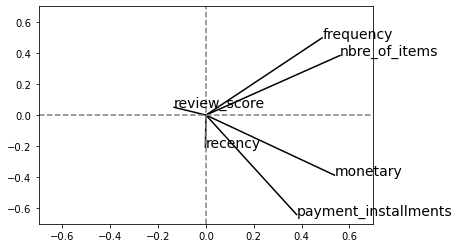

In [5]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, df_scaled.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

## 2-  Kmeans after PCA

### Recherche du nombre de clusters

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import decomposition


def get_score(X, a, b):
    '''
    Returns the graph of the inertia score to decide on the nomber of clusters (elbow method).

            Parameters:
                    X  : A dataframe
                    a (int): A decimal integer
                    b (int): Another decimal integer

            Returns:
                    plt.plot(range(a, b), inertia)
                    plt.title('Elbow method')
    '''
    inertia = []
    for k in range(a, b):
        kmeans = KMeans(n_clusters=k)
        y_pred = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
    plt.plot(range(a, b), inertia)
    plt.title('Elbow method')
    plt.show()

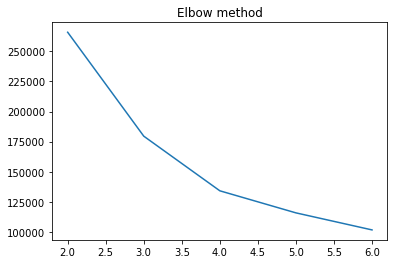

In [7]:
get_score(df_pca, 2, 7)

### Silhouette analysis
Dans ce graphe on a des doutes sur la methode du coude (elbow methode) entre les nombres de clusters 3 ou 4. Pour faire notre choix on a recours a la silhouette analysis

### Model avec nombre optimal de clusters

In [54]:
range_n_clusters = [3, 4]

In [2]:
import matplotlib.cm as cm


def silhouette_analysis(X, range_n_clusters):
    '''
        Returns the graph of the silhouette coefficients for each cluster in each model for n_cluster in range_n_clusters

                Parameters:
                        X : A Dataframe
                        range_n_clusters: An array of integers
        '''

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1) = plt.subplots()
        fig.set_size_inches(8, 8)
        ax1.set_xlim([-0.4, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color,
                              edgecolor=color, alpha=0.7)
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.show()

For n_clusters = 3 The average silhouette_score is : 0.36374119295665575


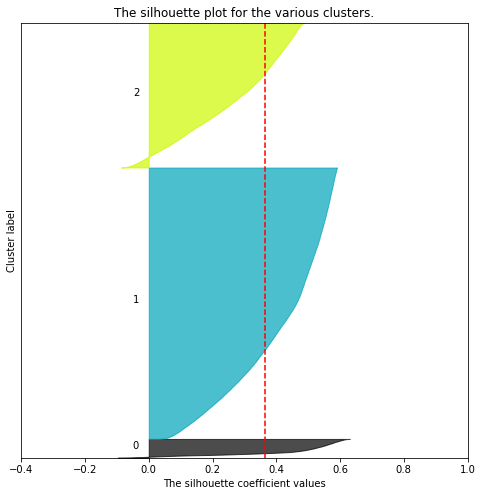

For n_clusters = 4 The average silhouette_score is : 0.3563463659960415


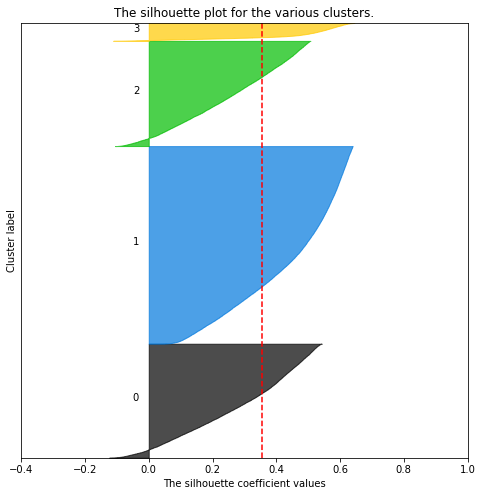

In [115]:
silhouette_analysis(df_pca, range_n_clusters)

### Conclusion
On choisit n_clusters=3

In [58]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(df_pca)
silhouette_avg = silhouette_score(
    df_pca, kmeans.labels_, sample_size=5000)
print('Silhouette score:', silhouette_avg)

Silhouette score: 0.36504113684521106


### Analyse exploratoitre de la classification :
Distribution des variables dans les differents clusters et repartition des clients par cluster

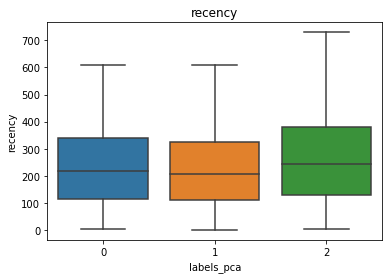

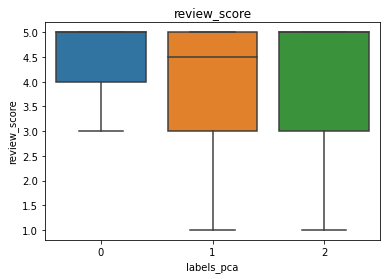

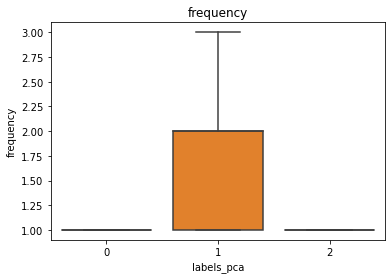

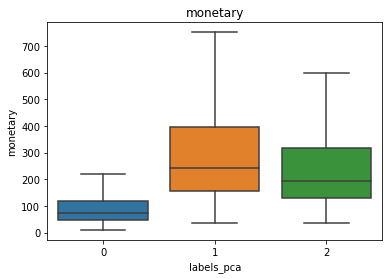

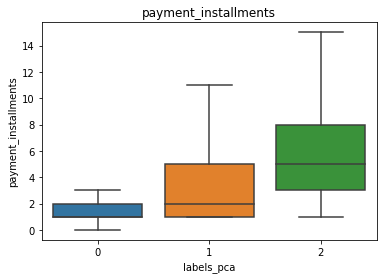

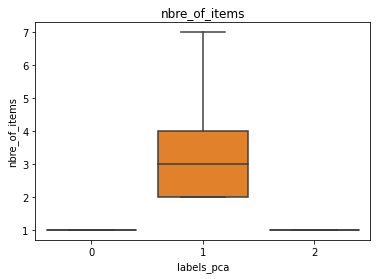

In [59]:
df['labels_pca'] = labels

for indic in df_scaled.columns:
    sns.boxplot(x='labels_pca', y=indic, showfliers=False, data=df)
    plt.title(indic)
    plt.show()

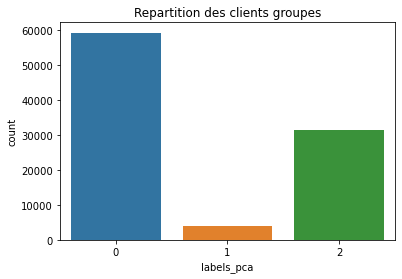

In [61]:
sns.countplot(x='labels_pca', data=df)
plt.title('Repartition des clients groupes')
plt.show()

### Conclusion : 
Les clusters ne sont pas pertinents pour l’objectif de la segmentation client
Groupe 1 représente les clients fréquents ayant acheté plusieurs articles
Groupe 0 et 2 sont divises par le montant de dépense. La récence n'est pas prise en compte de cette classification.




### Representation 3d des differents plans factoriels de la PCA

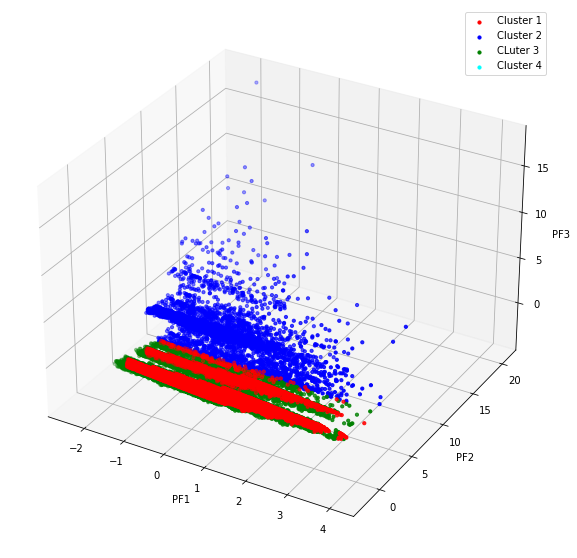

In [62]:
a = 2
b = 0
c = 1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_pca[labels == 0, a], df_pca[labels == 0, b],
           df_pca[labels == 0, c], s=10, c='red', label='Cluster 1')
ax.scatter(df_pca[labels == 1, a], df_pca[labels == 1, b],
           df_pca[labels == 1, c], s=10, c='blue', label='Cluster 2')
ax.scatter(df_pca[labels == 2, a], df_pca[labels == 2, b],
           df_pca[labels == 2, c], s=10, c='green', label='CLuter 3')
ax.scatter(df_pca[labels == 3, a], df_pca[labels == 3, b],
           df_pca[labels == 3, c], s=10, c='cyan', label='Cluster 4')
#ax.scatter(df_pca.values[labels == 4, a], df_rfm.values[labels == 4, b], df_rfm.values[labels == 4, c], s = 10, c = 'yellow', label = 'Cluster 4')
#ax.scatter(kmeans.cluster_centers_[:,a], kmeans.cluster_centers_[:,b],kmeans.cluster_centers_[:,c], s = 100, c = 'grey', label = 'Centroids')
ax.set_xlabel('PF1')
ax.set_ylabel('PF2')
ax.set_zlabel('PF3')
plt.legend()
plt.show()

## 3 -  Kmeans sur toutes les variables


### Recherche du nombre de clusters

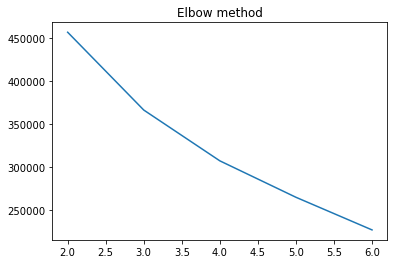

In [63]:
get_score(df_scaled, 2, 7)

For n_clusters = 3 The average silhouette_score is : 0.26277968699471765


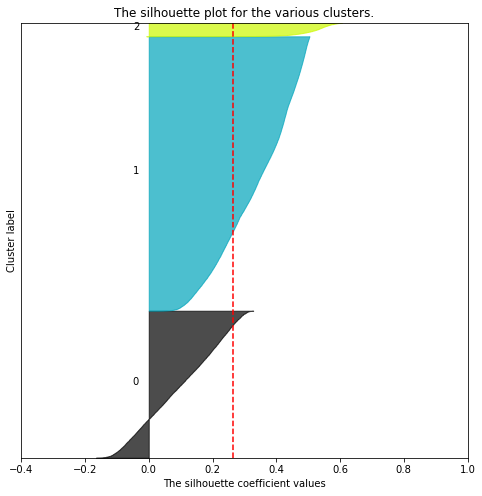

For n_clusters = 4 The average silhouette_score is : 0.27503112677425917


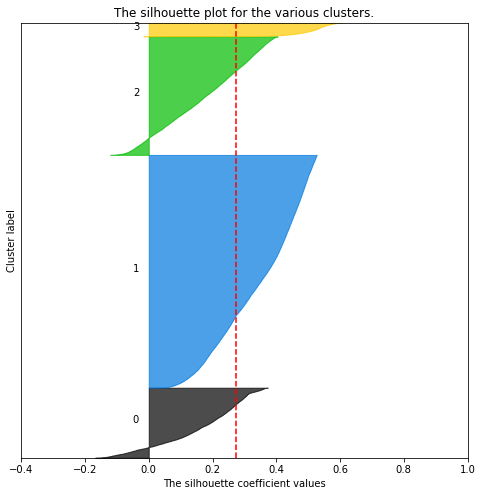

In [66]:
range_n_clusters = [3, 4]
silhouette_analysis(df_scaled, range_n_clusters)

### Conclusion :
on choisit n_clusters=4

### Modelisation 
Pour chaque model Kmeans nous allons stocker dans le dataframe **silhouette** le silhouette score et le nombre de clusters correspondant au meilleur model avec les variables selectionnees. Ce dataframe nous aidera a la fin pour choisir le meilleur model pour l'equipe marketing.
La fonction get_model() nous permettra d'avoir toutes les informations pertinente de la classification avec le nombre optimal de cluster en generant automatiquement en plus du score silhoutee moyen de la classification l'analuse exploratoitre de cette classification

In [8]:
silhouette = pd.DataFrame()

In [23]:
def get_model(X, nbr_clusters, name_of_variables):
    '''
       Returns the silhouette score average for the kmeans model of X with the corresponding numbet of cluster nbr_clusters 
       adds the resulting silhouette score and number of clusters to the silhouette table
       plots the boxplot distribution of the corresponding variables of the dataframe in each cluster 
       plots the distribution of clients in the different clusters

               Parameters:
                       X (DataFrame) : A dataframe
                       nbr_clusters (int): An integer
                       name_of_variables (str): A string of caracters
    '''
    kmeans = KMeans(n_clusters=nbr_clusters)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, kmeans.labels_, sample_size=5000)
    silhouette[name_of_variables] = [silhouette_avg, nbr_clusters]
    print('Silhouette score:', silhouette_avg)
    df['labels'] = labels

    for indic in X.columns:
        sns.boxplot(x='labels', y=indic, showfliers=False, data=df)
        plt.title(indic)
        plt.show()

    sns.countplot(x='labels', data=df)
    plt.title('Repartition des clients groupes')
    plt.show()

###  Description de la classification du model avec le nombre optimal de clusters:

Silhouette score: 0.269818137591351


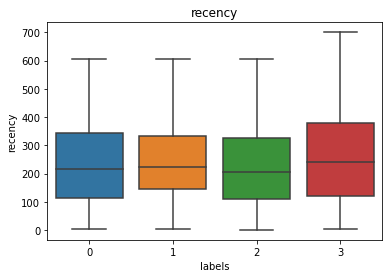

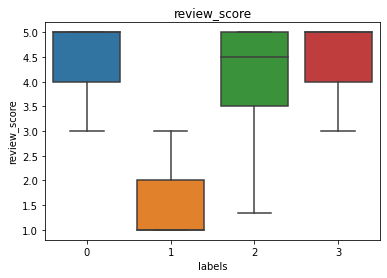

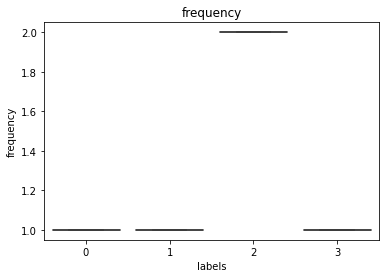

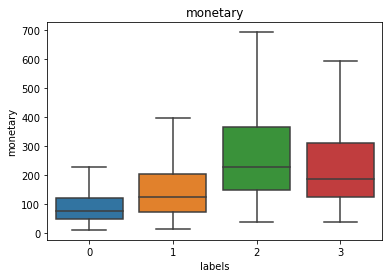

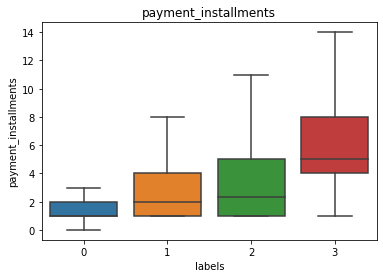

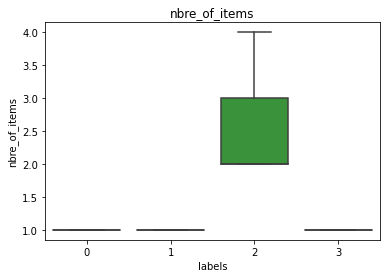

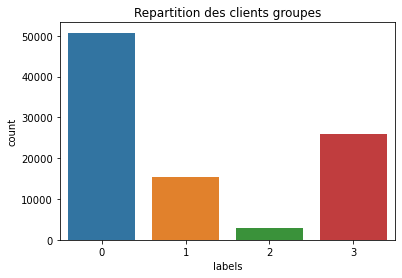

In [24]:
get_model(df_scaled, 4, "all")

### Conclusion
Les clusters ne sembles pas tres pertinents pour l'objectif de la classification. On voit bien un cluster avec les clients frequants mais les autres clusters ne semblent pas donnes des caracteristiques bien definis. Cela est probablementdu au grand nombre de variables. Nous allons faire des essais de classification avec differents lots de variables pour choisir le model le plus pertinent en terme de pertinence de la classification et du silhouette score

## 4 - DBSCAN sur toutes les variables
On va essayer le classificateur DBSCAN pour voir s'il donne de meilleurs resultats. Dans un premier temps nous feront une recherche du hyperparametre eps pour ensuite donner le model correspondant

In [3]:
from sklearn.cluster import DBSCAN


def search_dbscan(X, range_eps, nbr_samples):
    '''
       Returns the set of labels and the silhouette score of the DBSCAN model of X for each value of eps in range_eps
               Parameters:
                       X (DataFrame) : A panda data frame
                       range_eps : An array of decimals
                       nbr_samples (int): An integer
    '''

    for i in range_eps:
        print('eps_value :'+str(i))
        db = DBSCAN(eps=i, min_samples=nbr_samples).fit(X)
        labels = db.labels_
        print(set(labels))
        silhouette_avg = silhouette_score(X, labels, sample_size=4000)
        print('for eps' + str(i), 'silhouette score is', silhouette_avg)

In [78]:
range_eps = [0.6, 0.8, 1, 1.2]

In [77]:
search_dbscan(df_scaled, range_eps, df_scaled.shape[1]*2)

eps_value :0.6
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, -1}
for eps0.6 silhouette score is 0.026192222367832713
eps_value :0.8
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
for eps0.8 silhouette score is 0.2393775347159524
eps_value :1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
for eps1 silhouette score is 0.26167243505617965
eps_value :1.2
{0, 1, 2, 3, 4, 5, -1}
for eps1.2 silhouette score is 0.2750610642308364


On voit que eps optimal est 1.2. Je verifie si 1.3 ou 1.4 donne un meilleur resultat en terme de score silhouette ou de nombre de clusters

In [79]:
range_eps = [1.3, 1.4]

In [80]:
search_dbscan(df_scaled, range_eps, df_scaled.shape[1]*2)

eps_value :1.3
{0, 1, 2, 3, 4, 5, -1}
for eps1.3 silhouette score is 0.2742966083304898
eps_value :1.4
{0, 1, 2, 3, 4, 5, -1}
for eps1.4 silhouette score is 0.2701193569836715


In [4]:
def get_dbscan_model(X, eps, nbr_sample):
    '''
       Returns the silhouette score average for the DBSCAN model of X with the corresponding eps and min_sample 
       plots the boxplot distribution of the corresponding variables of the dataframe in each cluster 
       plots the distribution of clients in the different clusters

               Parameters:
                       X (DataFrame) : A panda data frame
                       eps (floata): A decimal
                       nbr_sample (int): An integer 
    '''

    db = DBSCAN(eps=eps, min_samples=nbr_sample).fit(X)
    labels_dbscan = db.labels_
    silhouette_avg = silhouette_score(X, labels_dbscan)
    print('Le score silhouette est : ', silhouette_avg)
    df['labels_dbscan'] = labels_dbscan

    for indic in X.columns:
        sns.boxplot(x='labels_dbscan', y=indic, showfliers=False, data=df)
        plt.title(indic)
        plt.show()
    sns.countplot(x='labels_dbscan', data=df)
    plt.title('Repartition des clients groupes')
    plt.show()

Le score silhouette est :  0.2718001126585469


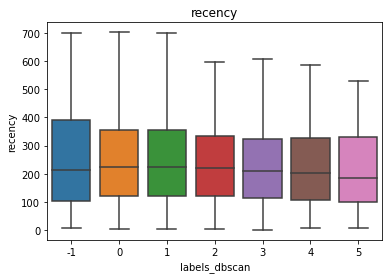

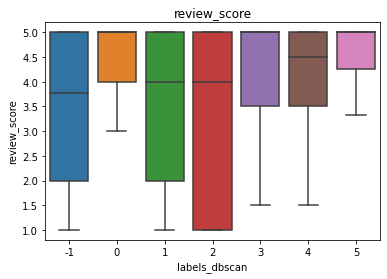

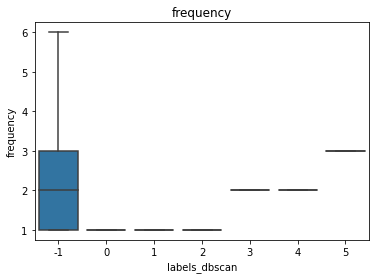

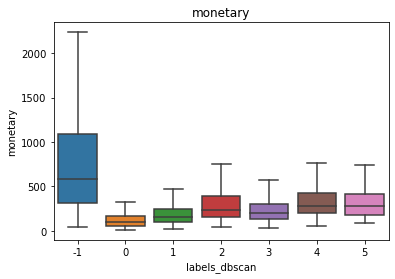

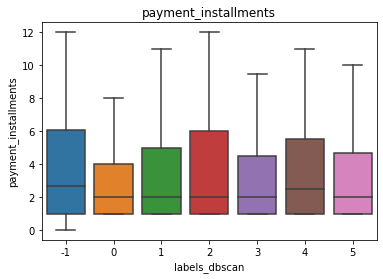

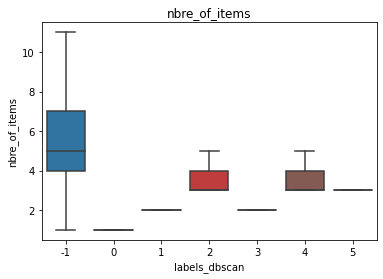

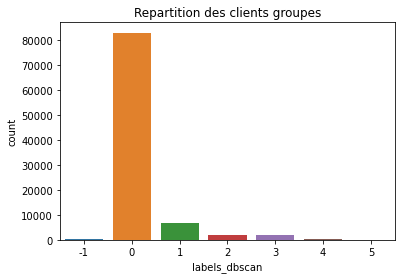

In [84]:
get_dbscan_model(df_scaled, 1.2, df_scaled.shape[1]*2)

### Conclusion
DBSCAN ne donne pas une bonne classification pour ce modele. On voit bien que la classification est tres assymetrique avec la majorite des clients dans le cluster 0, les 4 autres clusters sont tres minoritere et on ne peu pas comprendre le pertinence de cette classification pour l'equipe marketing. 

# 5 - Essai sur des combinaisons de variables du dataset
Faire des essai sur les variables les plus pertinentes pour une meilleure segmentation

## 1- Recency-Frequency-Monetary
On commencepar le modele de base. Pour ce model je vais fire la modelisation par Kmeans et par DBSCAN pour comparer encore une fois les resultats des 2 classificateurs

### Kmeans

In [11]:
df_rfm = df_scaled.drop(
    columns=['review_score', 'nbre_of_items',  'payment_installments'])

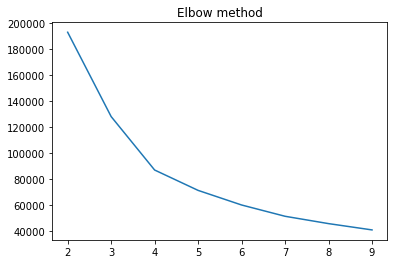

In [86]:
get_score(df_rfm, 2, 10)

Silhouette score: 0.3659554569740584


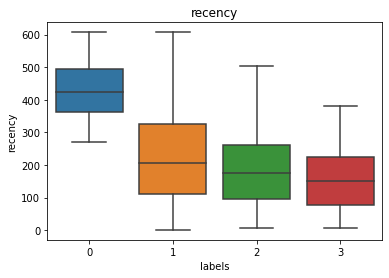

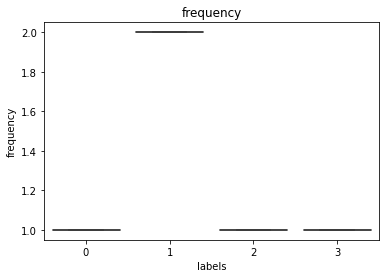

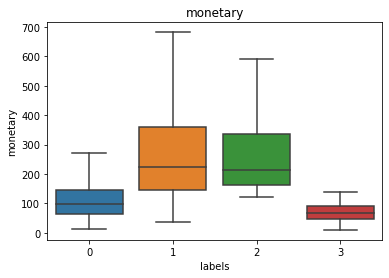

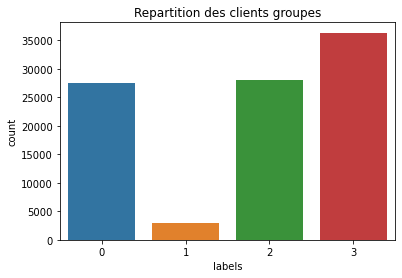

In [25]:
get_model(df_rfm, 4, 'Recency-Frequency-Monetary')

### Conclusion
Cette classification semble satisfaisante, elle categorise les clients par frequence, recence et budget. Elle peut satisfaire les objectifs de l'equipe marketing

### Silhouette sample score

For n_clusters = 4 The average silhouette_score is : 0.3694066698476895


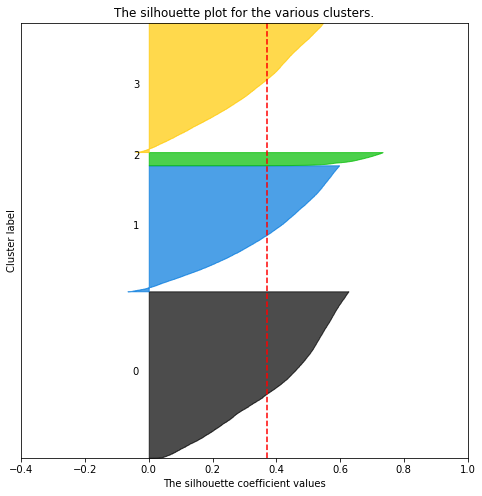

In [12]:
range_n_clusters = [4]
silhouette_analysis(df_rfm, range_n_clusters)

### Representation 3d de la classification

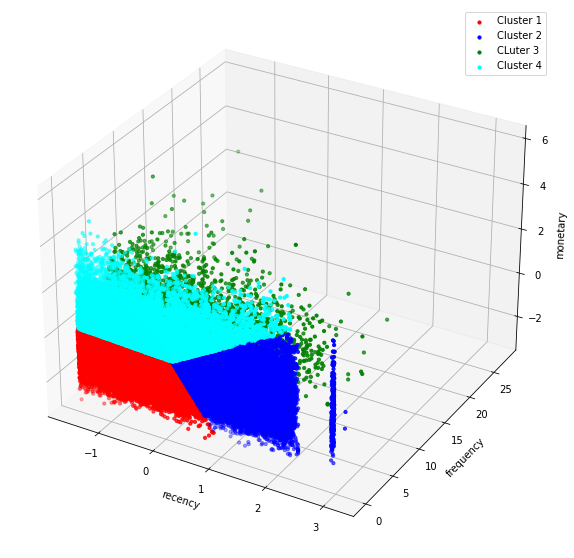

In [89]:
a = 0
b = 1
c = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_rfm.values[labels == 0, a], df_rfm.values[labels == 0, b],
           df_rfm.values[labels == 0, c], s=10, c='red', label='Cluster 1')
ax.scatter(df_rfm.values[labels == 1, a], df_rfm.values[labels == 1, b],
           df_rfm.values[labels == 1, c], s=10, c='blue', label='Cluster 2')
ax.scatter(df_rfm.values[labels == 2, a], df_rfm.values[labels == 2, b],
           df_rfm.values[labels == 2, c], s=10, c='green', label='CLuter 3')
ax.scatter(df_rfm.values[labels == 3, a], df_rfm.values[labels == 3, b],
           df_rfm.values[labels == 3, c], s=10, c='cyan', label='Cluster 4')
# ax.scatter(df_rfm.values[labels == 4, a], df_rfm.values[labels == 4, b],
#           df_rfm.values[labels == 4, c], s=10, c='yellow', label='Cluster 4')
# ax.scatter(kmeans.cluster_centers_[:, a], kmeans.cluster_centers_[
#           :, b], kmeans.cluster_centers_[:, c], s=100, c='grey', label='Centroids')
ax.set_xlabel(df_rfm.columns[a])
ax.set_ylabel(df_rfm.columns[b])
ax.set_zlabel(df_rfm.columns[c])
plt.legend()
plt.show()

### DBSCAN

#### Recherche de l'hyperparametre eps

In [93]:
range_eps = [0.4, 0.6, 0.8]
search_dbscan(df_rfm, range_eps, df_rfm.shape[1]*2)

eps_value :0.4
{0, 1, 2, 3, 4, 5, 6, -1}
for eps0.4 silhouette score is 0.4327597953572456
eps_value :0.6
{0, 1, 2, 3, -1}
for eps0.6 silhouette score is 0.6847874482432005
eps_value :0.8
{0, 1, 2, 3, 4, -1}
for eps0.8 silhouette score is 0.6886994206323178


#### Model et analyse exploratoire de la classification

Le score silhouette est :  0.686460362661407


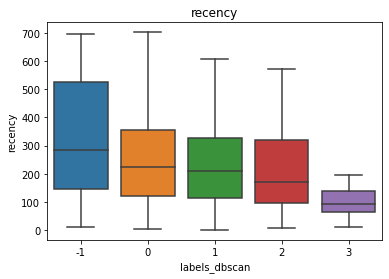

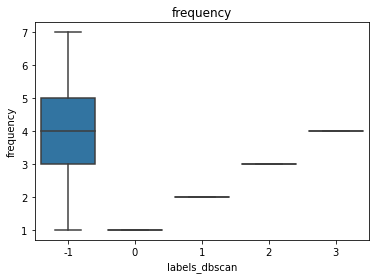

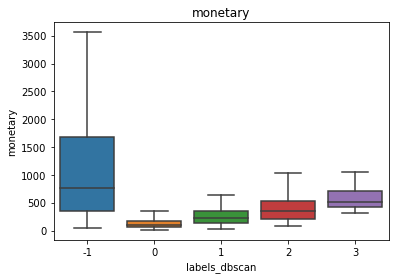

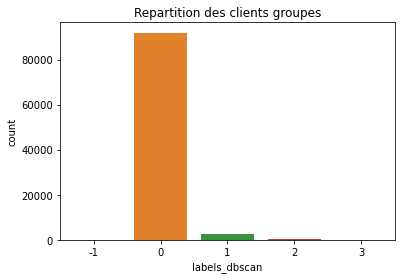

In [108]:
get_dbscan_model(df_rfm, 0.6, df_rfm.shape[1]*2)

#### Representation 3D

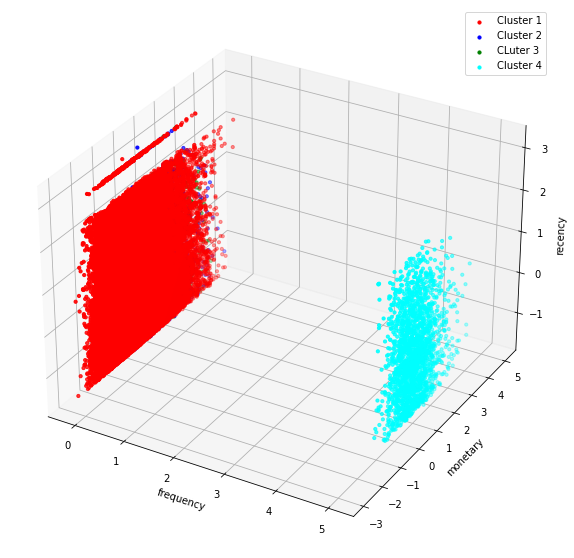

In [121]:
a = 1
b = 2
c = 0
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_rfm.values[labels_dbscan == 0, a], df_rfm.values[labels_dbscan == 0, b],
           df_rfm.values[labels_dbscan == 0, c], s=10, c='red', label='Cluster 1')
ax.scatter(df_rfm.values[labels_dbscan == 1, a], df_rfm.values[labels_dbscan == 1, b],
           df_rfm.values[labels_dbscan == 1, c], s=10, c='blue', label='Cluster 2')
ax.scatter(df_rfm.values[labels_dbscan == 2, a], df_rfm.values[labels_dbscan == 2, b],
           df_rfm.values[labels_dbscan == 2, c], s=10, c='green', label='CLuter 3')
ax.scatter(df_rfm.values[labels_dbscan == 3, a], df_rfm.values[labels_dbscan == 3, b],
           df_rfm.values[labels_dbscan == 3, c], s=10, c='cyan', label='Cluster 4')
# ax.scatter(df_rfm.values[labels_dbscan == 4, a], df_rfm.values[labels_dbscan == 4, b],
# df_rfm.values[labels_dbscan == 4, c], s=10, c='yellow', label='Cluster 5')
# ax.scatter(kmeans.cluster_centers_[:, a], kmeans.cluster_centers_[
#           :, b], kmeans.cluster_centers_[:, c], s=100, c='grey', label='Centroids')
ax.set_xlabel(df_rfm.columns[a])
ax.set_ylabel(df_rfm.columns[b])
ax.set_zlabel(df_rfm.columns[c])
plt.legend()
plt.show()

#### Conclusion
La classification de DBSCAN bien que plus efficace en terme de silhouette score ne donne pas une bonne segmentation des clients comme elle est base essentiellement sur la frequence

## 2- Recency-Frequency-Monetary-nbre_of_items

In [13]:
df_rfmnb = df_scaled.drop(
    columns=['review_score',  'payment_installments'])

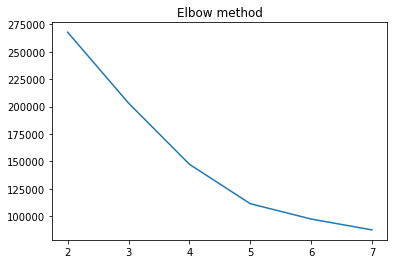

In [97]:
get_score(df_rfmnb, 2, 8)

Silhouette score: 0.36168783354015693


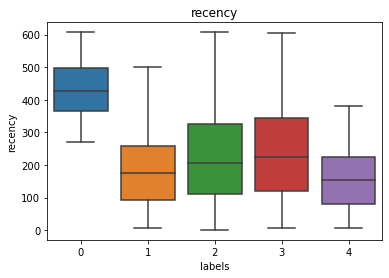

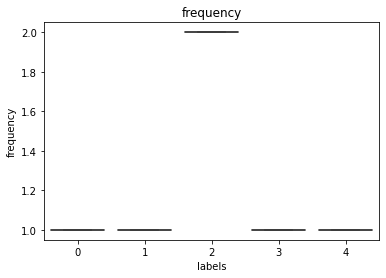

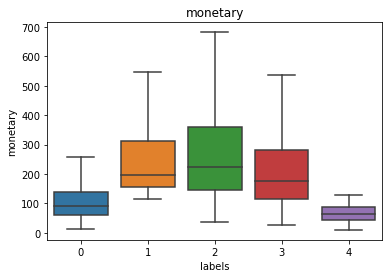

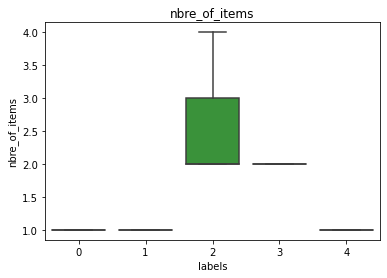

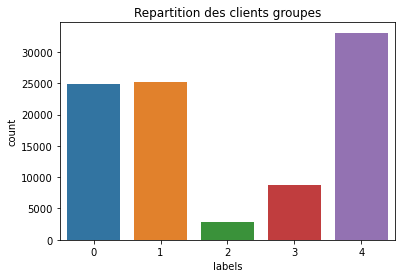

In [26]:
get_model(df_rfmnb, 5, 'Recency-Frequency-Monetary-Nbre_of_items')

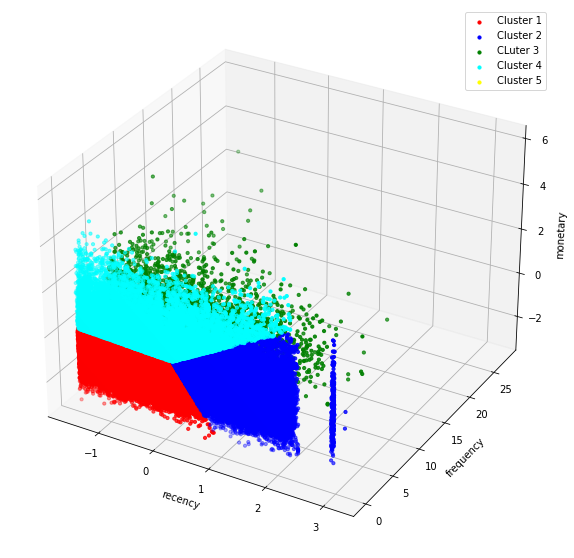

In [99]:
a = 0
b = 1
c = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_rfmnb.values[labels == 0, a], df_rfmnb.values[labels == 0, b],
           df_rfmnb.values[labels == 0, c], s=10, c='red', label='Cluster 1')
ax.scatter(df_rfmnb.values[labels == 1, a], df_rfmnb.values[labels == 1, b],
           df_rfmnb.values[labels == 1, c], s=10, c='blue', label='Cluster 2')
ax.scatter(df_rfmnb.values[labels == 2, a], df_rfmnb.values[labels == 2, b],
           df_rfmnb.values[labels == 2, c], s=10, c='green', label='CLuter 3')
ax.scatter(df_rfmnb.values[labels == 3, a], df_rfmnb.values[labels == 3, b],
           df_rfmnb.values[labels == 3, c], s=10, c='cyan', label='Cluster 4')
ax.scatter(df_rfmnb.values[labels == 4, a], df_rfmnb.values[labels == 4, b],
           df_rfmnb.values[labels == 4, c], s=10, c='yellow', label='Cluster 5')
# ax.scatter(kmeans.cluster_centers_[:, a], kmeans.cluster_centers_[
# :, b], kmeans.cluster_centers_[:, c], s=100, c='grey', label='Centroids')
ax.set_xlabel(df_rfmnb.columns[a])
ax.set_ylabel(df_rfmnb.columns[b])
ax.set_zlabel(df_rfmnb.columns[c])
plt.legend()
plt.show()

For n_clusters = 5 The average silhouette_score is : 0.3594283546078828


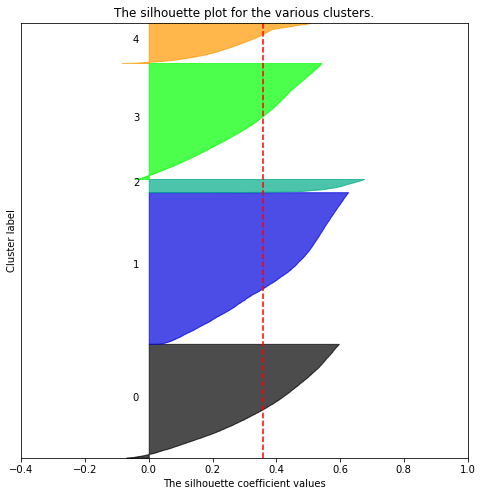

In [14]:
range_n_clusters = [5]
silhouette_analysis(df_rfmnb, range_n_clusters)

### Conclusion
Cette classification semble satisfaisante en terme de repartition des clusters, en plus du cluster des clients frequents elle present egalement un cluster des clients qui ont achete une fois mais plusieurs articles. Les categories des clients recents et anciens sont aussi bien determines 

## 3 - Recency-Monetary-nbre_of_items
On va essayer de faire un modele en enlevant la variable frequency pour voir l'effet sur cette classification

In [15]:
df_rmnb = df_scaled.drop(
    columns=['review_score', 'frequency', 'payment_installments'])

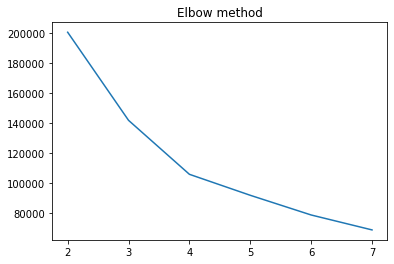

In [101]:
get_score(df_rmnb, 2, 8)

Silhouette score: 0.35264177864438456


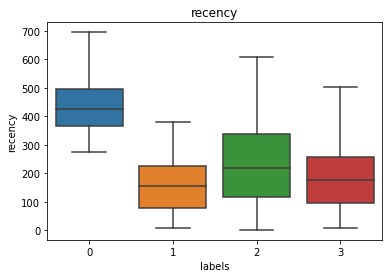

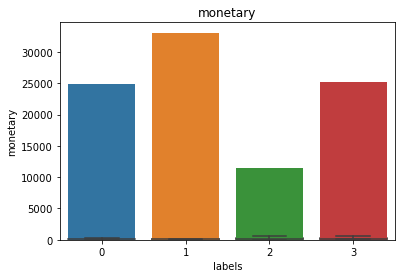

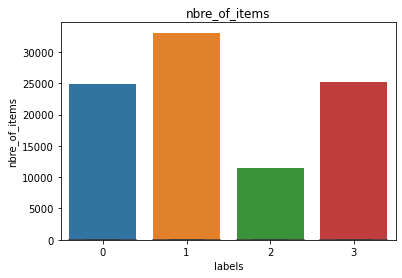

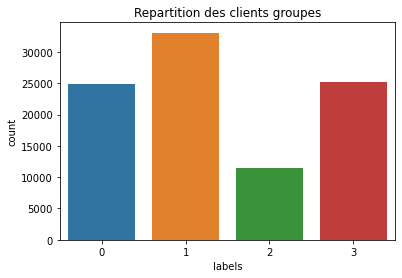

In [16]:
get_model(df_rmnb, 4, 'Recency-Monetary-Nbre_of_items')

For n_clusters = 4 The average silhouette_score is : 0.3497759137125261


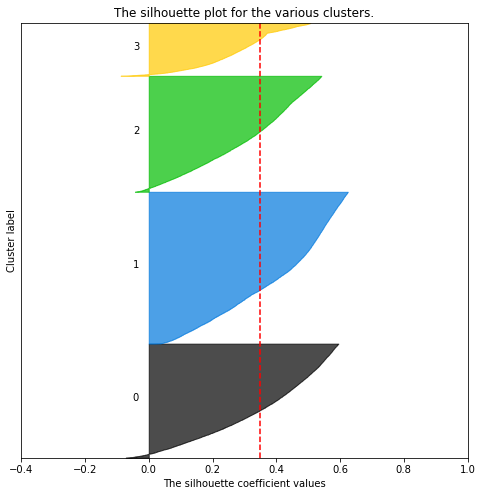

In [15]:
range_n_clusters = [4]
silhouette_analysis(df_rmnb, range_n_clusters)

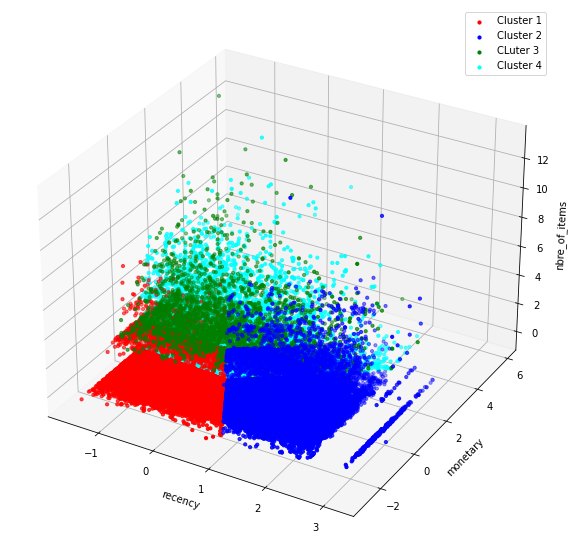

In [103]:
a = 0
b = 1
c = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_rmnb.values[labels == 0, a], df_rmnb.values[labels == 0, b],
           df_rmnb.values[labels == 0, c], s=10, c='red', label='Cluster 1')
ax.scatter(df_rmnb.values[labels == 1, a], df_rmnb.values[labels == 1, b],
           df_rmnb.values[labels == 1, c], s=10, c='blue', label='Cluster 2')
ax.scatter(df_rmnb.values[labels == 2, a], df_rmnb.values[labels == 2, b],
           df_rmnb.values[labels == 2, c], s=10, c='green', label='CLuter 3')
ax.scatter(df_rmnb.values[labels == 3, a], df_rmnb.values[labels == 3, b],
           df_rmnb.values[labels == 3, c], s=10, c='cyan', label='Cluster 4')
# ax.scatter(df_rmnb.values[labels == 4, a], df_rmnb.values[labels == 4, b],
#           df_rmnb.values[labels == 4, c], s=10, c='yellow', label='Cluster 4')
# ax.scatter(kmeans.cluster_centers_[:, a], kmeans.cluster_centers_[
# :, b], kmeans.cluster_centers_[:, c], s=100, c='grey', label='Centroids')
ax.set_xlabel(df_rmnb.columns[a])
ax.set_ylabel(df_rmnb.columns[b])
ax.set_zlabel(df_rmnb.columns[c])
plt.legend()
plt.show()

### Conclusion
Cette repartition ne semble pas donner plus d'informations que la classification avec frequency a part que le groupe des clients frequents n'existe plus. Pour les autres clusters la repartition est plus ou moins la meme.

### DBSCAN
On va essayer de faire une classification par DBSCAN en l'absence de la frequence pour voir s'il propose une meilleure classification

In [123]:
range_eps = [0.4, 0.6, 0.8]
search_dbscan(df_rmnb, range_eps, df_rmnb.shape[1])

eps_value :0.4
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1}
for eps0.4 silhouette score is 0.32981819971380816
eps_value :0.6
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
for eps0.6 silhouette score is 0.3632069736820471
eps_value :0.8
{0, 1, 2, 3, 4, 5, -1}
for eps0.8 silhouette score is 0.3926201686492002


Le score silhouette est :  0.38588624145023454


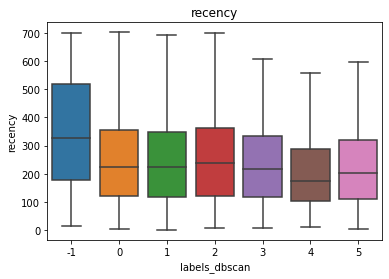

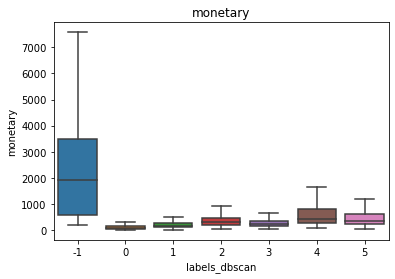

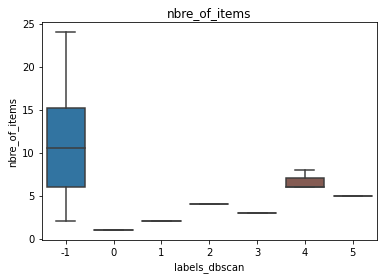

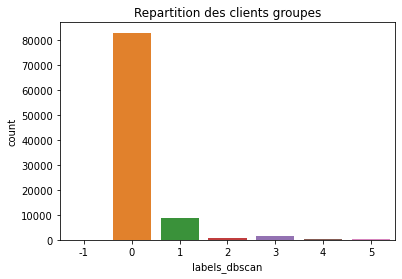

In [9]:
get_dbscan_model(df_rmnb, 0.8, df_rmnb.shape[1])

### Conclusion
Encore une fois on voit que le classificateur DBSCAN n'est pas adapter a ce type de modeles. La classification se fait surtout en terme de nombre d'articles achetee. Les plus gros depenseurs sont dans le goupe -1 (noise). Pour le reste des modeles on utilisera uniquement le classificateur Kmeans 

## 4 - Recency - monetary - nbre_of_items-review

In [17]:
df_rmrev = df_scaled.drop(
    columns=['frequency', 'nbre_of_items', 'payment_installments'])

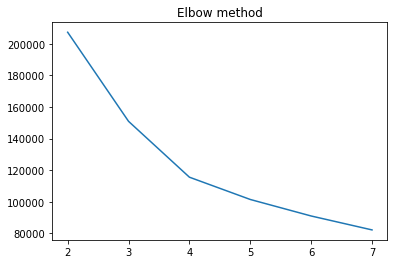

In [105]:
get_score(df_rmrev, 2, 8)

Silhouette score: 0.3077811540022845


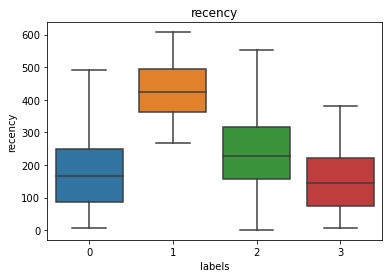

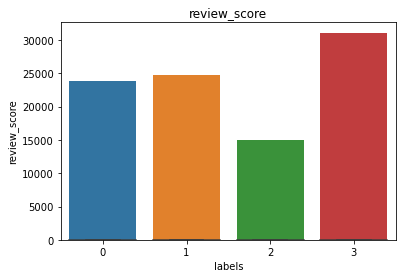

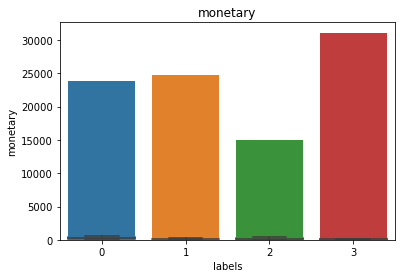

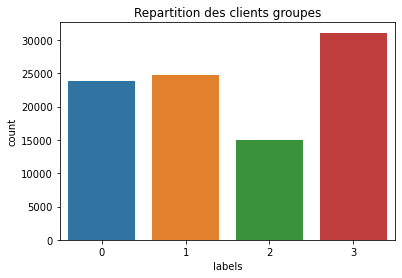

In [18]:
get_model(df_rmrev, 4, ' Recency - Monetary - Nbre_of_items - Review')

For n_clusters = 4 The average silhouette_score is : 0.3115941966714836


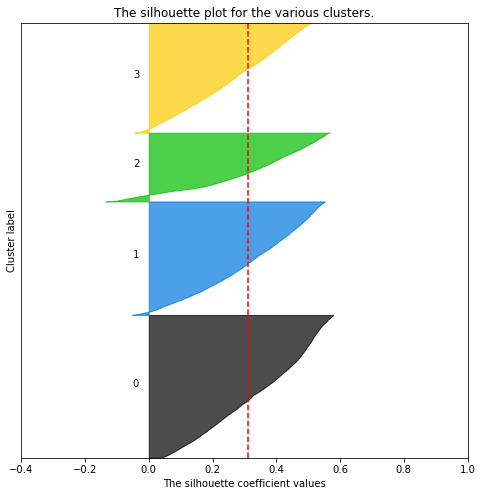

In [18]:
range_n_clusters = [4]
silhouette_analysis(df_rmrev, range_n_clusters)

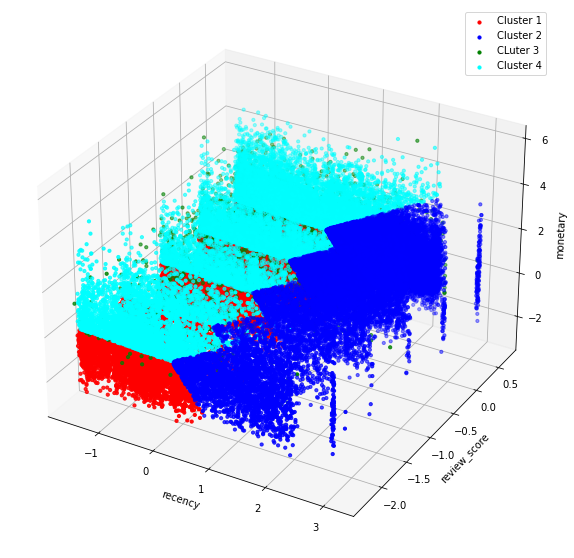

In [110]:
a = 0
b = 1
c = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_rmrev.values[labels == 0, a], df_rmrev.values[labels == 0, b],
           df_rmrev.values[labels == 0, c], s=10, c='red', label='Cluster 1')
ax.scatter(df_rmrev.values[labels == 1, a], df_rmrev.values[labels == 1, b],
           df_rmrev.values[labels == 1, c], s=10, c='blue', label='Cluster 2')
ax.scatter(df_rmrev.values[labels == 2, a], df_rmrev.values[labels == 2, b],
           df_rmrev.values[labels == 2, c], s=10, c='green', label='CLuter 3')
ax.scatter(df_rmrev.values[labels == 3, a], df_rmrev.values[labels == 3, b],
           df_rmrev.values[labels == 3, c], s=10, c='cyan', label='Cluster 4')
# ax.scatter(df_rmrev.values[labels == 4, a], df_rmrev.values[labels == 4, b],
#          df_rmrev.values[labels == 4, c], s=10, c='yellow', label='Cluster 4')
# ax.scatter(kmeans.cluster_centers_[:, a], kmeans.cluster_centers_[
#         :, b], kmeans.cluster_centers_[:, c], s=100, c='grey', label='Centroids')
ax.set_xlabel(df_rmrev.columns[a])
ax.set_ylabel(df_rmrev.columns[b])
ax.set_zlabel(df_rmrev.columns[c])
plt.legend()
plt.show()

## 5 - Recency- monetary - nbre_of_items - payment installments

In [19]:
df_rfmrev = df_scaled.drop(columns=['frequency', 'review_score'])

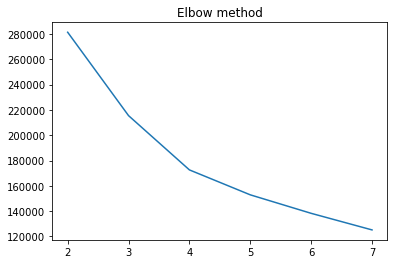

In [112]:
get_score(df_rfmrev, 2, 8)

Silhouette score: 0.29015143464987087


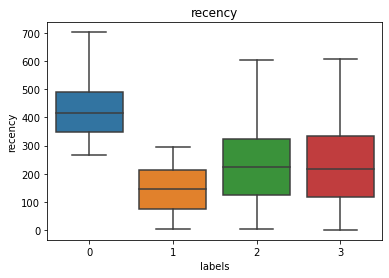

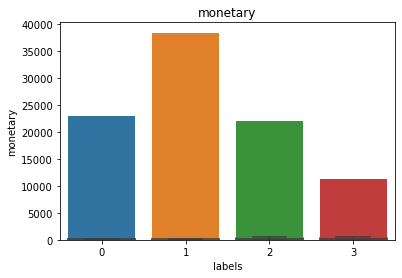

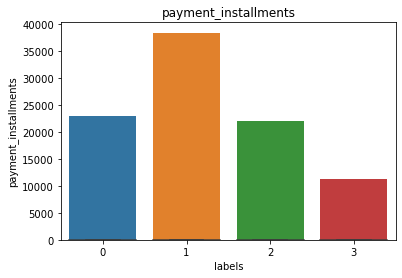

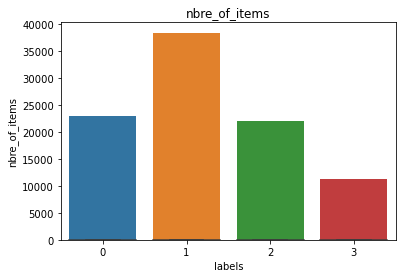

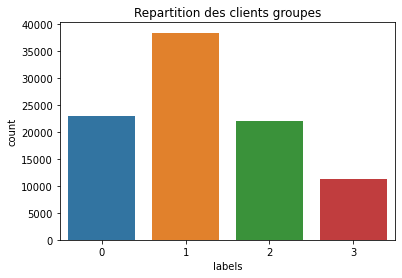

In [20]:
get_model(df_rfmrev, 4, 'Recency - Monetary - Nbre_of_items - Payment_installments')

For n_clusters = 4 The average silhouette_score is : 0.29313521094081574


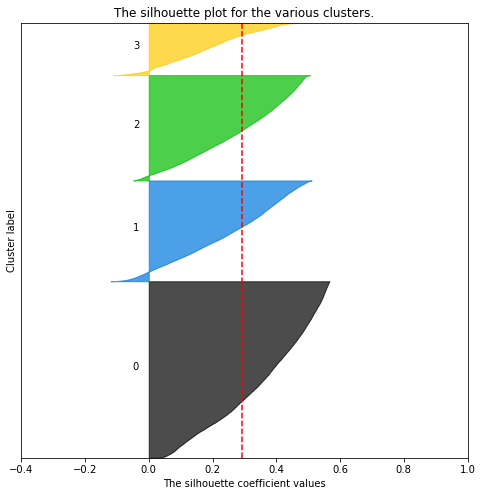

In [20]:
range_n_clusters = [4]
silhouette_analysis(df_rfmrev, range_n_clusters)

# Resume des resultats

In [21]:
silhouette

,all,Recency-Frequency-Monetary,Recency-Frequency-Monetary-Nbre_of_items,Recency-Monetary-Nbre_of_items,Recency - Monetary - Nbre_of_items - Review,Recency - Monetary - Nbre_of_items - Payment_installments
0,0.279906,0.376168,0.356941,0.352642,0.307781,0.290151
1,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000


In [22]:
silhouette = silhouette.rename(
    index={0: 'Silhouette score', 1: ' Number of clusters'})
silhouette

,all,Recency-Frequency-Monetary,Recency-Frequency-Monetary-Nbre_of_items,Recency-Monetary-Nbre_of_items,Recency - Monetary - Nbre_of_items - Review,Recency - Monetary - Nbre_of_items - Payment_installments
Silhouette score,0.279906,0.376168,0.356941,0.352642,0.307781,0.290151
Number of clusters,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000
